170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


782/782 ━━━━━━━━━━━━━━━━━━━━ 109s 137ms/step - accuracy: 0.2527 - loss: 1.9884 - val_accuracy: 0.4862 - val_loss: 1.4013
Epoch 2/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 107s 136ms/step - accuracy: 0.4657 - loss: 1.4779 - val_accuracy: 0.5552 - val_loss: 1.2165
Epoch 3/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 142s 136ms/step - accuracy: 0.5262 - loss: 1.3426 - val_accuracy: 0.5838 - val_loss: 1.1599
Epoch 4/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 108s 137ms/step - accuracy: 0.5579 - loss: 1.2582 - val_accuracy: 0.6153 - val_loss: 1.1002
Epoch 5/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 140s 135ms/step - accuracy: 0.5829 - loss: 1.1767 - val_accuracy: 0.6605 - val_loss: 0.9653
Epoch 6/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 103s 131ms/step - accuracy: 0.5974 - loss: 1.1379 - val_accuracy: 0.6695 - val_loss: 0.9373
Epoch 7/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 102s 130ms/step - accuracy: 0.6142 - loss: 1.0920 - val_accuracy: 0.6700 - val_loss: 0.9675
Epoch 8/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 105s 134ms/step - accuracy: 0.6304 - loss: 1.06

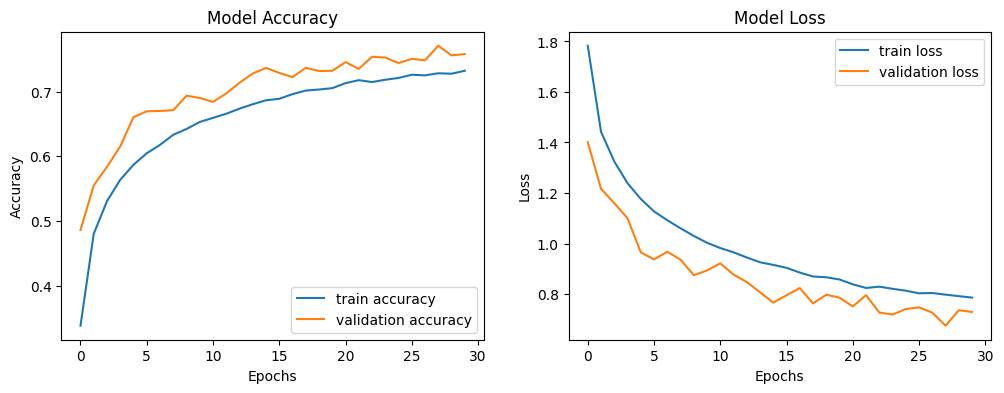

In [1]:
# Import required libraries
from pyspark.sql import SparkSession
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

# Initialize Spark session
spark = SparkSession.builder \
    .appName("CNN_Spark_Project") \
    .config("spark.executor.memory", "2g") \
    .config("spark.executor.cores", "2") \
    .config("spark.task.cpus", "1") \
    .getOrCreate()

# Load and preprocess the CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

# Data augmentation to increase the training set variability
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)
datagen.fit(x_train)

# Define CNN model architecture
def create_cnn_model():
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

cnn_model = create_cnn_model()

# Train the model with data augmentation
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

history = cnn_model.fit(
    datagen.flow(x_train, y_train, batch_size=64),
    epochs=30,
    validation_data=(x_test, y_test),
    callbacks=[early_stopping]
)

# Evaluate the model on test data
test_loss, test_accuracy = cnn_model.evaluate(x_test, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Generate classification report and confusion matrix
y_pred = cnn_model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

print("Classification Report:\n", classification_report(y_true, y_pred_classes))
print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred_classes))

# Plot accuracy and loss graphs
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')

plt.show()

# Save the trained model
cnn_model.save("cnn_cifar10_model.h5")

# Save evaluation metrics to a report
with open("evaluation_report.txt", "w") as f:
    f.write(f"Test Accuracy: {test_accuracy * 100:.2f}%\n")
    f.write("Classification Report:\n")
    f.write(classification_report(y_true, y_pred_classes))
    f.write("\nConfusion Matrix:\n")
    f.write(str(confusion_matrix(y_true, y_pred_classes)))
